In [1]:
import os
import pandas as pd
import geopandas as gpd

# os.environ["USE_PYGEOS"] = os.environ.get("USE_PYGEOS", "0")
local_crs = 32636
# path to data
example_data_path = "./data"

In [2]:
# load aggregated info we have
aggregated_blocks = gpd.read_parquet(os.path.join(example_data_path, "data_getter_blocks.parquet"))
accessibility_matrix = pd.read_pickle(os.path.join(example_data_path, "data_getter_matrix.pickle"))

In [3]:
# load data required for service graphs creation
schools = gpd.read_parquet(os.path.join(example_data_path, "schools.parquet"))
kindergartens = gpd.read_parquet(os.path.join(example_data_path, "kindergartens.parquet"))
recreational_areas = gpd.read_parquet(os.path.join(example_data_path, "recreational_areas.parquet")).rename_geometry('geometry')

hospitals = gpd.read_file(os.path.join(example_data_path, "hospitals.geojson"))
pharmacies = gpd.read_file(os.path.join(example_data_path, "pharmacies.geojson"))
policlinics = gpd.read_file(os.path.join(example_data_path, "policlinics.geojson"))

# services should be specified as a dictionary
services = {"kindergartens": kindergartens}

In [4]:
services = {"schools": schools, "kindergartens": kindergartens, "recreational_areas": recreational_areas,
            "hospitals": hospitals, "pharmacies": pharmacies, "policlinics": policlinics}

In [5]:
from masterplan_tools.models import City

city_model = City(
  blocks_gdf=aggregated_blocks, 
  matrix=accessibility_matrix
)

In [12]:
city_model.update_service_type_layer(city_model['schools'], schools)
city_model.update_service_type_layer(city_model['kindergartens'], kindergartens)
city_model.update_service_type_layer(city_model['recreational_areas'], recreational_areas)
city_model.update_service_type_layer(city_model['hospitals'], hospitals)
city_model.update_service_type_layer(city_model['pharmacies'], pharmacies)
city_model.update_service_type_layer(city_model['policlinics'], policlinics)

In [16]:
from masterplan_tools.method.provision import Provision
provision = Provision(city_model=city_model)

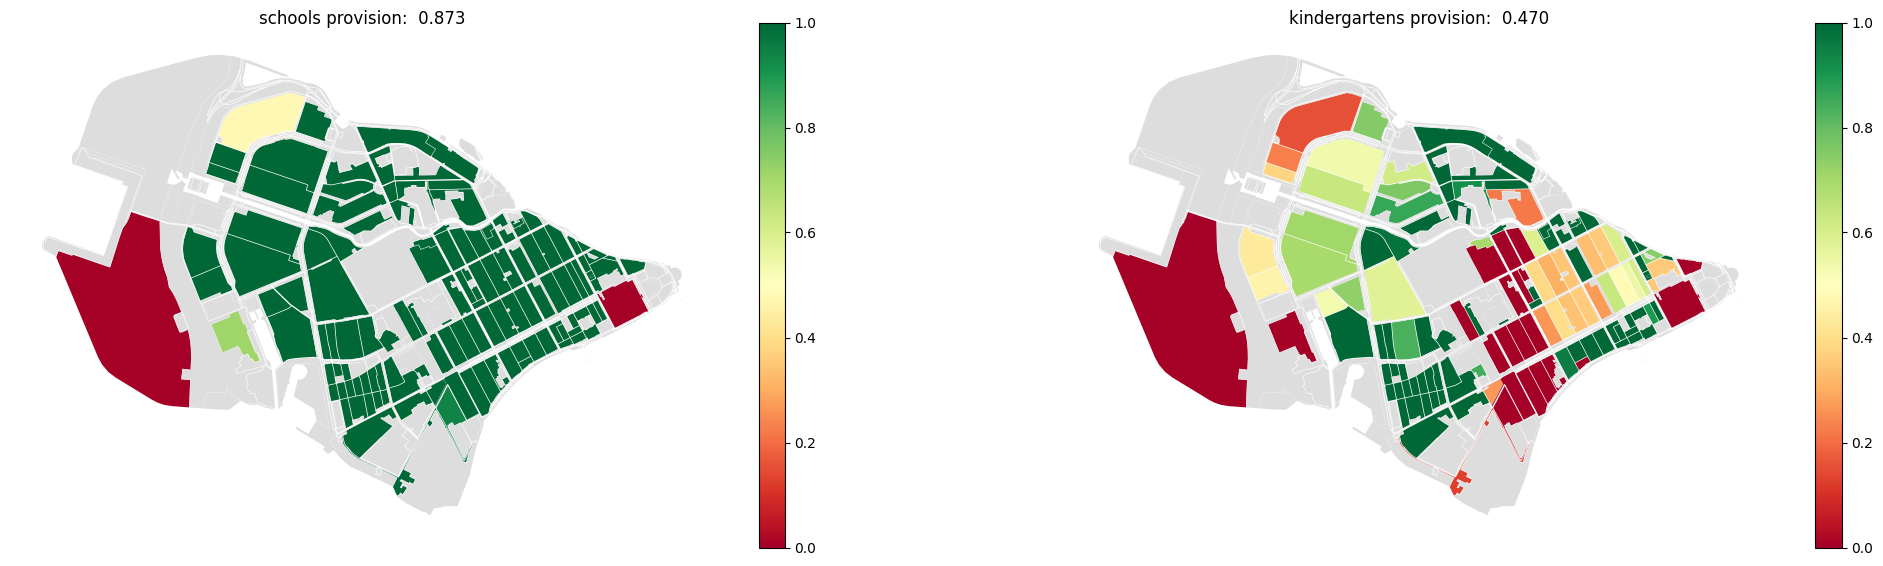

In [20]:
provisions_before = provision.calculate_provisions(['schools', 'kindergartens'], method='iterative')
provision.plot_provisions(provisions_before)

In [38]:
selected_block = city_model[47]
update = {
  selected_block.id : {
    'population': 0,
    'kindergartens': 1600,
    'schools': 0
  }
} 
update_gdf = gpd.GeoDataFrame.from_dict(update, orient='index')

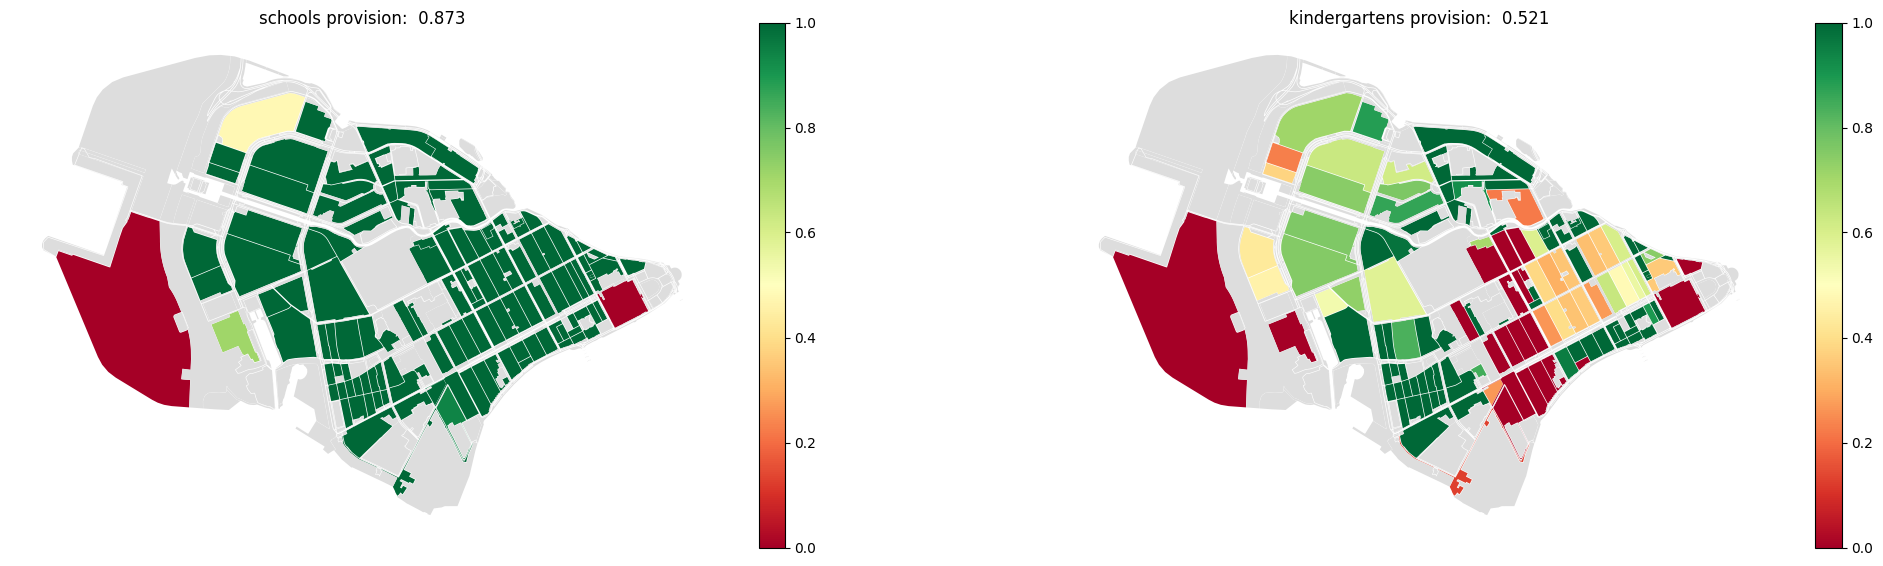

In [39]:
provisions_after = provision.calculate_provisions(['schools', 'kindergartens'], update_gdf,  method='iterative')
provision.plot_provisions(provisions_after)